在每一次迭代中，梯度下降使用整个训练数据集来计算梯度，因此它有时也被称为批量梯度下降（batch gradient descent）。而随机梯度下降在每次迭代中**只随机采样一个样本来计算梯度**。正如我们在前几章中所看到的，我们**还可以在每轮迭代中随机均匀采样多个样本来组成一个小批量，然后使用这个小批量来计算梯度**。下面就来描述小批量随机梯度下降。


设目标函数$f(\boldsymbol{x}): \mathbb{R}^d \rightarrow \mathbb{R}$。在迭代开始前的时间步设为0。该时间步的自变量记为$\boldsymbol{x}_0\in \mathbb{R}^d$，通常由随机初始化得到。在接下来的每一个时间步$t>0$中，**小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量$\mathcal{B}_t$**。我们可以通过重复采样（sampling with replacement）或者不重复采样（sampling without replacement）得到一个小批量中的各个样本。前者允许同一个小批量中出现重复的样本，后者则不允许如此，且更常见。对于这两者间的任一种方式，都可以使用

$$
\boldsymbol{g}_t \leftarrow \nabla f_{\mathcal{B}_t}(\boldsymbol{x}_{t-1}) = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla f_i(\boldsymbol{x}_{t-1})
$$

来计算时间步$t$的小批量$\mathcal{B}_t$上目标函数位于$\boldsymbol{x}_{t-1}$处的梯度$\boldsymbol{g}_t$。这里$|\mathcal{B}|$代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度$\boldsymbol{g}_t$也是对梯度$\nabla f(\boldsymbol{x}_{t-1})$的无偏估计。给定学习率$\eta_t$（取正数），小批量随机梯度下降对自变量的迭代如下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \eta_t \boldsymbol{g}_t.$$

**基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减，例如$\eta_t=\eta t^\alpha$（通常$\alpha=-1$或者$-0.5$）、$\eta_t = \eta \alpha^t$（如$\alpha=0.95$）或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小**。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。


小批量随机梯度下降中每次迭代的计算开销为$\mathcal{O}(|\mathcal{B}|)$。**当批量大小为1时，该算法即为随机梯度下降；当批量大小等于训练数据样本数时，该算法即为梯度下降**。当批量较小时，每次迭代中使用的样本少，这会导致并行处理和内存使用效率变低。这使得在计算同样数目样本的情况下比使用更大批量时所花时间更多。当批量较大时，每个小批量梯度里可能含有更多的冗余信息。为了得到较好的解，批量较大时比批量较小时需要计算的样本数目可能更多，例如增大迭代周期数。

## 7.3.1 读取数据

本章里我们将使用一个来自NASA的**测试不同飞机机翼噪音**的数据集来比较各个优化算法 [1]。我们使用该数据集的前1,500个样本和5个特征，并使用标准化对数据进行预处理。

In [1]:
%matplotlib inline
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.append("..") 
import d2lzh_tensorflow2 as d2l

def get_data_ch7():  # 本函数已保存在d2lzh_tensorflow2包中方便以后使用
    data = np.genfromtxt('../../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)   #这个做法在 numpy 可以实现嘛？
    return tf.convert_to_tensor(data[:1500, :-1],dtype=tf.float32), tf.convert_to_tensor(data[:1500, -1],dtype=tf.float32)

features,labels = get_data_ch7()
features.shape# 

TensorShape([1500, 5])

## 7.3.2 从零开始实现

3.2节（线性回归的从零开始实现）中已经实现过小批量随机梯度下降算法。我们在这里将它的输入参数变得更加通用，主要是**为了方便本章后面介绍的其他优化算法也可以使用同样的输入**。具体来说，我们添加了一个状态输入`states`并将超参数放在字典`hyperparams`里。此外，我们将**在训练函数里对各个小批量样本的损失求平均**，因此优化算法里的梯度不需要除以批量大小。

In [2]:
def sgd(params, states,hyperparams,grads):
    for i,p in enumerate(params):
        p.assign_sub(hyperparams['lr'] * grads[i])  # 更新参数

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。它初始化一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。

In [5]:
# 本函数已保存在d2lzh_tensorflow2包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
             batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = tf.Variable(np.random.normal(0, 0.01, size=(features.shape[1],1)), dtype=tf.float32)
    b = tf.Variable(tf.zeros(1, dtype=tf.float32))
    
    def eval_loss():
        return np.array(tf.reduce_mean(loss(net(features, w,b), labels)))    # 这里求了平均
    
    ls = [eval_loss()]
    data_iter = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)
    data_iter = data_iter.shuffle(100)
    
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X,y) in enumerate(data_iter):   # 输入已经是矩阵的形式了
            with tf.GradientTape() as tape:
                l = tf.reduce_mean(loss(net(X,w,b), y ))  # 使用平均损失
                
            grads = tape.gradient(l, [w,b])
            optimizer_fn([w,b],states, hyperparams, grads) # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())    # 每100个样本记录下当前训练误差
                
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

当批量大小为样本总数1,500时，**优化使用的是梯度下降**（总样本数是1500）。梯度下降的1个迭代周期对模型参数只迭代1次。可以看到6次迭代后目标函数值（训练损失）的下降趋向了平稳。

loss: 0.244967, 0.010999 sec per epoch


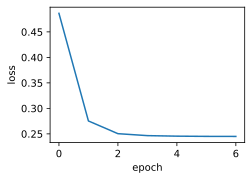

In [6]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

**当批量大小为1时，优化使用的是随机梯度下降**。为了简化实现，**有关（小批量）随机梯度下降的实验中，我们未对学习率进行自我衰减，而是直接采用较小的常数学习率**。**随机梯度下降中，每处理一个样本会更新一次自变量（模型参数）**，一个迭代周期里会对自变量进行1,500次更新。可以看到，目标函数值的下降在1个迭代周期后就变得较为平缓。

loss: 0.252428, 6.885999 sec per epoch


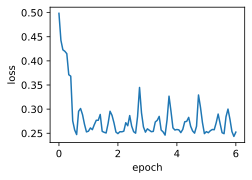

In [8]:
train_sgd(0.005, 1,6)

虽然**随机梯度下降**和**梯度下降**在一个迭代周期里都处理了1,500个样本，但实验中随机梯度下降的一个迭代周期耗时更多。这是因为随机梯度下降在一个迭代周期里做了更多次的自变量迭代（这是为什么?)，而且单样本的梯度计算难以有效利用矢量计算。

当批量大小为10时，优化使用的是小批量随机梯度下降。它在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。

loss: 0.246694, 0.669003 sec per epoch


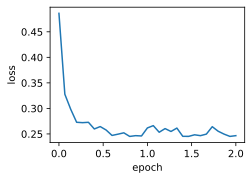

In [9]:
train_sgd(0.05, 10)

## 7.3.3 简洁实现

同样，我们也无须自己实现小批量随机梯度下降算法。**tensorflow.keras.optimizers 模块**提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化model 所有参数的优化器实例，并指定学习率为0.05的**小批量随机梯度下降**（SGD）为优化算法

In [10]:
from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.05)

In [12]:
# 本函数已保存在d2lzh_tensorflow2包中方便以后使用，事实上用不到trainer_hyperparams这个参数，这样写是为了和原书保持一致
def train_tensorflow2_ch7(trainer_name, trainer_hyperparams, features, labels,
                         batch_size=10, num_epochs=2):
    # 初始化模型
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1))
    
    loss = tf.losses.MeanSquaredError()
    
    def eval_loss():
        return np.array(tf.reduce_mean(loss(net(features), labels)))
    
    ls = [eval_loss()]
    data_iter = tf.data.Dataset.from_tensor_slices((features,labels)).batch(batch_size)
    data_iter = data_iter.shuffle(100)
 
    # 创建Trainer实例来迭代模型参数
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with tf.GradientTape() as tape:
                l = tf.reduce_mean(loss(net(X), y))  # 使用平均损失
                        
            grads = tape.gradient(l, net.trainable_variables)
            trainer.apply_gradients(zip(grads, net.trainable_variables))  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

使用Tensorflow2重复上一个实验。

loss: 0.556403, 1.226000 sec per epoch


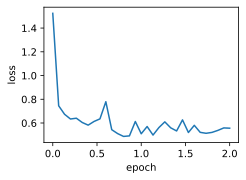

In [13]:
train_tensorflow2_ch7('trainer', {'learning_rate': 0.05}, features, labels, 10)

## 小结

* 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
* 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
* 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间。


## 参考文献

[1] 飞机机翼噪音数据集。https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise

-----------

> 注：除代码外本节与原书此节基本相同，[原书传送门](https://zh.d2l.ai/chapter_optimization/minibatch-sgd.html)

